# **Sistem Rekomendasi Buku Berbasis Hybrid Approach (Content-Based Filtering dan Collaborative Filtering)**

# Sumber Data dan Rujukan
**Dataset:** [Book Recomendation Dataset](https://www.kaggle.com/code/fahadmehfoooz/book-recommendation-system/notebook)

* Dua file utama yang akan digunakan:

  * `Books.csv` — metadata buku (yang berisi ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L')
  * `user_rating` — hasil merge `Ratings.csv dan Users.csv` yang berisi 'User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age'

# Instal dan Import Library

In [1]:
!pip install numpy==1.26.4

menginstal versi tertentu dari library NumPy, yaitu versi 1.26.4,untuk Mencegah error kompatibilitas dengan library surprise.

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469542 sha256=cd4ec1e06ee43a10794db92ae23bd78c2465270df344883fafbd0b7c9f618a05
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


instal surprice -library yang khusus untuk membangun sistem rekomendasi

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set(style='whitegrid')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD , accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict
from surprise.model_selection import train_test_split

pertama import library yang digunakan:
- pandas : Mengolah dan menganalisis data dalam bentuk dataframe.
- numpy : Mengolah array dan matriks numerik.
- matplotlib.pyplot : Membuat visualisasi data dalam bentuk grafik dan plot.
- seaborn : Membuat visualisasi data yang lebih estetis dan informatif.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


menghubungkan ke drive

In [6]:
book_df = pd.read_csv('/content/drive/MyDrive/all_data/Books.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/all_data/Ratings.csv').sample(40000)
user_df = pd.read_csv('/content/drive/MyDrive/all_data/Users.csv')
user_rating_df = ratings_df.merge(user_df, left_on = 'User-ID', right_on = 'User-ID')

/tmp/ipython-input-6-2552064112.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_df = pd.read_csv('/content/drive/MyDrive/all_data/Books.csv')


memanggil data.csv dan melakukan merge(penggabungan data) dataframe ratings_df dan user_df berdasarkan kolom User-ID. Hasilnya disimpan dalam dataframe user_rating_df

In [7]:
print('Kolom pada book_df:', book_df.columns)
print('Kolom pada user_rating_df:', user_rating_df.columns)

Kolom pada book_df: Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Kolom pada user_rating_df: Index(['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age'], dtype='object')


melihat isi kolom book dan user rating

# EDA (Eksplanatory Data Analisis)

In [8]:
print (book_df.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

melihat 5 baris awal dasatet book

In [9]:
print(ratings_df.head())

        User-ID        ISBN  Book-Rating
606902   146457  0446862541            9
429232   102647  0316037451            0
962193   232131  0671638483            0
606603   146348  0805057900            0
446600   107021  0740719645            0


5 kolom awal ratings

In [10]:
print(user_df.head())

   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN


melihat 5 kolom awal users

In [11]:
print(user_rating_df.head())

   User-ID        ISBN  Book-Rating                    Location   Age
0   146457  0446862541            9    alameda, california, usa  43.0
1   102647  0316037451            0    modesto, california, usa  14.0
2   232131  0671638483            0    oakland, california, usa   NaN
3   146348  0805057900            0         tigard, oregon, usa   NaN
4   107021  0740719645            0  indianapolis, indiana, usa  45.0


melihat 5 kolom awal user_rating

In [12]:
print("\nbook_df info:")
book_df.info()

print("\nratings_df info:")
ratings_df.info()

print("\nuser_df info:")
user_df.info()

print("\nuser_rating_df info:")
user_rating_df.info()


book_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB

ratings_df info:
<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 606902 to 217580
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      40000 non-null  int64 
 1   ISBN         40000 non-null  object
 2   Book-Rating  40000 non-null  int64 
dt

insight

book_df: 271.360 baris data buku
- Tidak ada missing value yang signifikan
- Semua kolom memiliki tipe data object (string)

ratings_df: 40.000 baris data rating (sampel)
- Tidak ada missing value
- Kolom User-ID dan Book-Rating memiliki tipe data integer dan isbn object

user_df: 278.858 baris data pengguna
- Ada missing value pada kolom Age (sekitar 39% data tidak memiliki nilai Age)
- Kolom User-ID memiliki tipe data integer, Age memiliki tipe data float

user_rating_df:
- 40.000 baris data rating yang digabungkan dengan data pengguna
- Ada missing value pada kolom Age (sekitar 27% data tidak memiliki nilai Age)



In [13]:
print("Jumlah missing values di book_df:")
print(book_df.isnull().sum())
print("\nJumlah data duplikat:", book_df.duplicated().sum())

Jumlah missing values di book_df:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Jumlah data duplikat: 0


insight :
- Kolom Book-Author dan publisher memiliki 2 missing values
- Kolom Image-URL-L memiliki 3 missing values
- Jumlah data duplikat tidak ada data duplikat (0 baris)

In [14]:
print("Jumlah missing values di user_rating_df:")
print(user_rating_df.isnull().sum())
print("\nJumlah data duplikat:", user_rating_df.duplicated().sum())

Jumlah missing values di user_rating_df:
User-ID            0
ISBN               0
Book-Rating        0
Location           0
Age            10724
dtype: int64

Jumlah data duplikat: 0


insight
- Kolom Age memiliki 10.724 missing values
- Kolom lainnya tidak memiliki missing values
- Tidak ada data duplikat (0 baris)


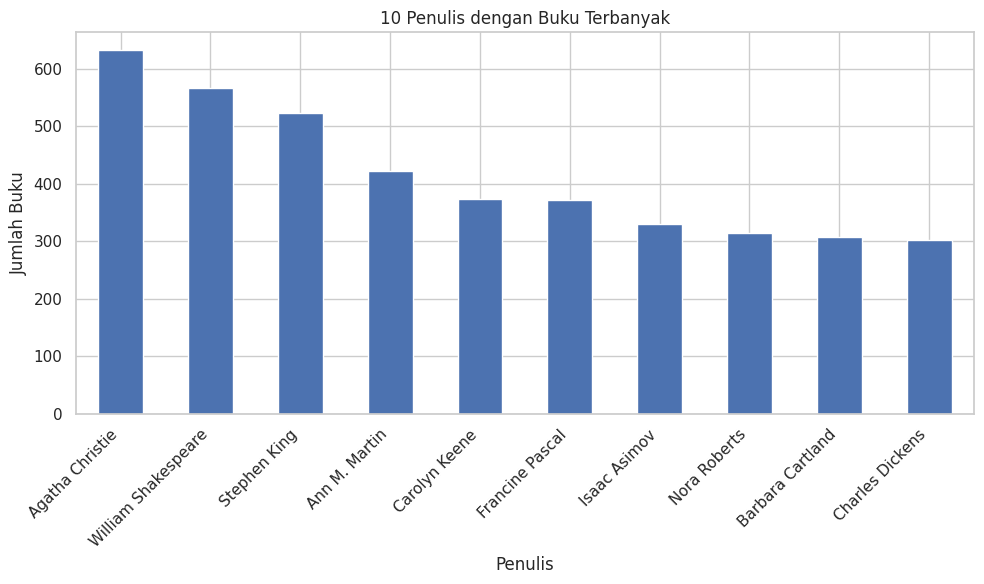

In [15]:
plt.figure(figsize=(10, 6))
book_df['Book-Author'].value_counts().head(10).plot(kind='bar')
plt.title('10 Penulis dengan Buku Terbanyak')
plt.xlabel('Penulis')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Top 10 Penulis diisi oleh nama-nama besar dalam dunia fiksi seperti Agatha Christie, Stephen King, dan William Shakespeare.

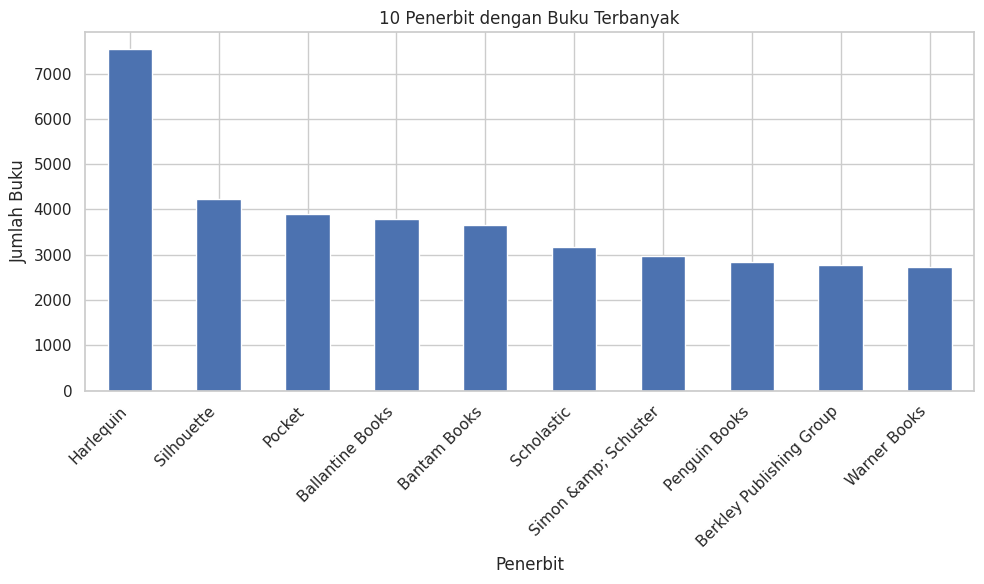

In [16]:
plt.figure(figsize=(10, 6))
book_df['Publisher'].value_counts().head(10).plot(kind='bar')
plt.title('10 Penerbit dengan Buku Terbanyak')
plt.xlabel('Penerbit')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Top 10 Penerbit didominasi oleh penerbit-penerbit besar yang terkenal dengan buku fiksi pasar massal seperti Harlequin, Silhouette, dan Pocket.

In [17]:
rata_rata_rating_buku = user_rating_df['Book-Rating'].mean()
print(f"Rata-rata rating buku: {rata_rata_rating_buku:.2f}")

Rata-rata rating buku: 2.88


insght :rata-rata rating buku (2.88) menjadi sangat rendah. Perilaku ini harus ditangani secara khusus.

/tmp/ipython-input-18-543331511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=user_rating_df, palette='rocket')


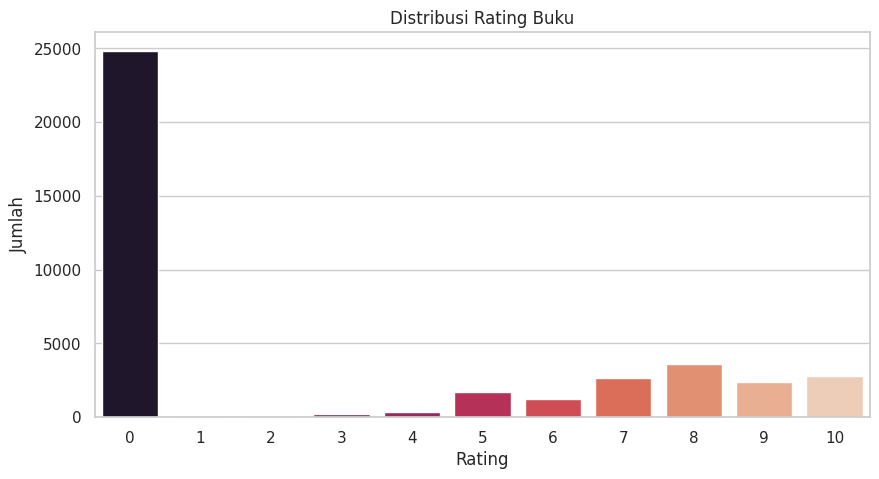

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Book-Rating', data=user_rating_df, palette='rocket')
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

 insight : terlihat bahwa rating 0 sangat mendominasi. Dalam konteks dataset ini, rating 0 sering diartikan sebagai rating implisit (pengguna berinteraksi dengan buku tapi tidak memberi skor),Ini perlu jadi pertimbangan saat data preparation.

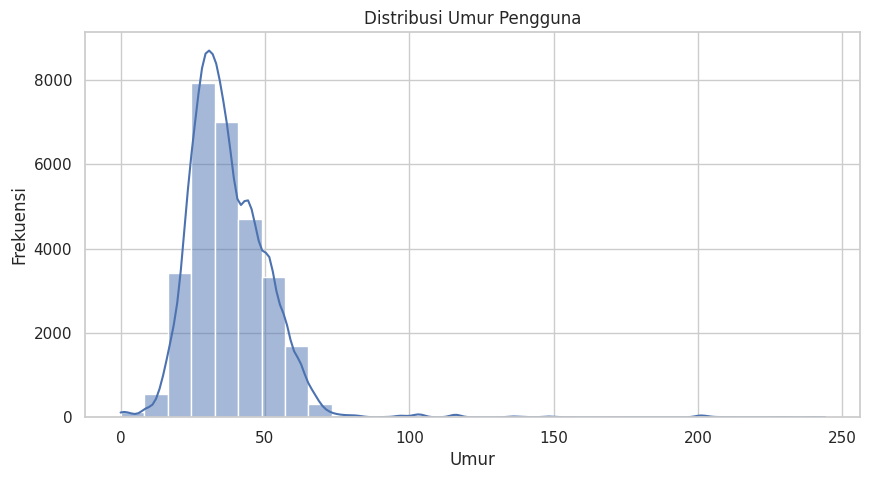

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(user_rating_df['Age'].dropna(), bins=30, kde=True)
plt.title('Distribusi Umur Pengguna')
plt.xlabel('Umur')
plt.ylabel('Frekuensi')
plt.show()

insight: terlihat data umur yang tidak realistis (yakni > 100 atau < 5) perlu dibersihkan.

In [20]:
user_rating_counts = user_rating_df['User-ID'].value_counts()
book_rating_counts = user_rating_df['ISBN'].value_counts()

print(f"Rata-rata rating per pengguna: {user_rating_counts.mean():.2f}")
print(f"Rata-rata rating per buku: {book_rating_counts.mean():.2f}")

Rata-rata rating per pengguna: 2.84
Rata-rata rating per buku: 1.34


insight : Rata-rata rating per buku" hanya 1.33(kemungkinan sebagian besar buku dalam dataset ini hanya pernah diberi rating oleh satu atau dua orang)

In [21]:
book_df['Year-Of-Publication'] = pd.to_numeric(book_df['Year-Of-Publication'], errors='coerce')
book_df = book_df.dropna(subset=['Year-Of-Publication'])
book_df['Year-Of-Publication'] = book_df['Year-Of-Publication'].astype(int)
print("Tahun-tahun publikasi yang unik (setelah konversi):")
print(sorted(book_df['Year-Of-Publication'].dropna().unique()))

Tahun-tahun publikasi yang unik (setelah konversi):
[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


/tmp/ipython-input-21-178748162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df['Year-Of-Publication'] = book_df['Year-Of-Publication'].astype(int)


- mengubah tipe data Year-Of-Publication yang bertipe object,menjadi angka.

In [22]:
print("Statistik Deskriptif untuk Kolom Umur:")
print(user_rating_df['Age'].describe())

Statistik Deskriptif untuk Kolom Umur:
count    29276.000000
mean        37.323268
std         14.510020
min          0.000000
25%         28.000000
50%         35.000000
75%         45.000000
max        244.000000
Name: Age, dtype: float64


insight :Data usia mengandung informasi berguna, tapi juga memiliki banyak nilai tidak wajar. Oleh karena itu, sebelum digunakan untuk analisis lebih lanjut atau modeling, perlu dilakukan pembersihan (data cleaning) terhadap kolom ini.



In [23]:
correlation_df = pd.merge(user_rating_df, book_df[['ISBN', 'Year-Of-Publication']], on='ISBN', how='left')

cleaned_corr_df = correlation_df.dropna(subset=['Year-Of-Publication', 'Age']) # Hapus baris dgn NaN di kolom ini
cleaned_corr_df = cleaned_corr_df[
    (cleaned_corr_df['Year-Of-Publication'] >= 1900) &
    (cleaned_corr_df['Year-Of-Publication'] <= 2025)
]

cleaned_corr_df = cleaned_corr_df[
    (cleaned_corr_df['Age'] >= 5) &
    (cleaned_corr_df['Age'] <= 100)
]

print(f"Jumlah data setelah dibersihkan: {len(cleaned_corr_df)}")

Jumlah data setelah dibersihkan: 25699


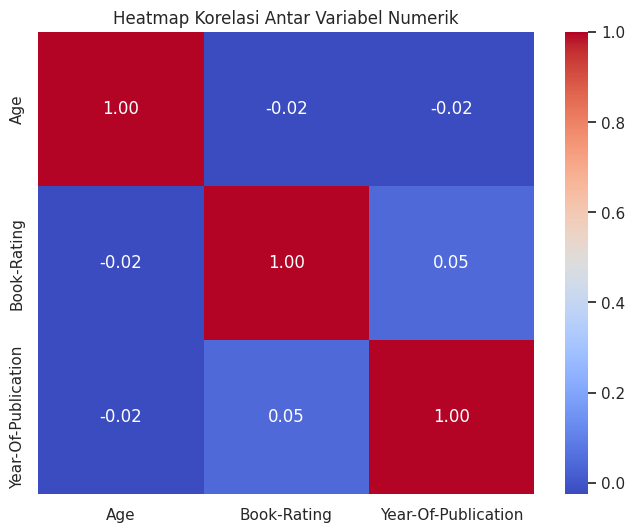

                          Age  Book-Rating  Year-Of-Publication
Age                  1.000000    -0.024049            -0.020973
Book-Rating         -0.024049     1.000000             0.045879
Year-Of-Publication -0.020973     0.045879             1.000000


In [24]:
numerical_cols = cleaned_corr_df[['Age', 'Book-Rating', 'Year-Of-Publication']]

correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.show()

print(correlation_matrix)

- Age vs Book-Rating: -0.02 : Umur pengguna tidak menentukan apakah mereka akan memberi rating tinggi atau rendah. Pengguna muda, dewasa, maupun yang lebih tua memiliki kecenderungan rating yang serupa.
- Age vs Year-Of-Publication: -0.02: Tidak ada tren yang menunjukkan bahwa pengguna dari kelompok umur tertentu lebih menyukai buku-buku dari era tertentu (misalnya, pengguna muda tidak secara signifikan lebih banyak membaca buku baru).
- Book-Rating vs Year-Of-Publication: 0.05: Buku-buku baru tidak secara otomatis mendapatkan rating yang lebih tinggi dibandingkan buku-buku yang lebih tua, dan sebaliknya.

---

# **Data Preparation**

## Membersihkan Data Outlier dan Tidak Valid

In [25]:
print(f"Jumlah baris book_df sebelum dibersihkan: {len(book_df)}")

Jumlah baris book_df sebelum dibersihkan: 271357


* melihat jumlah baris sebelum dibersihkan

In [26]:
book_df['Year-Of-Publication'] = pd.to_numeric(book_df['Year-Of-Publication'], errors='coerce')

* Mengubah 'Year-Of-Publication' ke numerik, error menjadi NaN

In [27]:
book_df.dropna(subset=['Year-Of-Publication'], inplace=True) # Hapus baris dengan NaN di tahun
book_df = book_df.loc[
    (book_df['Year-Of-Publication'] >= 1900) &
    (book_df['Year-Of-Publication'] <= 2025)
]

*  memfilter tahun yang valid (1900 - 2025) dan hapus NaN

In [28]:
book_df['Year-Of-Publication'] = book_df['Year-Of-Publication'].astype(int)
print(f"Jumlah baris book_df setelah dibersihkan: {len(book_df)}")

Jumlah baris book_df setelah dibersihkan: 266723


*  Jumlah baris book_df setelah dibersihkan: 266723 dan konversi ke integer setelah dibersihkan

In [29]:
user_rating_df.dropna(subset=['Age'], inplace=True) # Hapus baris dengan NaN di umur
user_rating_df = user_rating_df.loc[
    (user_rating_df['Age'] >= 5) &
    (user_rating_df['Age'] <= 100) ]

* Pada kolom age data yang kosong dihapus (baris dengan NaN pada kolom Age dihapus). Setelah itu, dilakukan pembersihan outlier, yaitu usia di luar rentang 5 hingga 100 tahun.

## Preprocessing untuk Model Content-Based Filtering

In [30]:
book_df.isnull().sum()
book_df.dropna(subset=['Book-Author', 'Publisher'], inplace=True)

* Cek missing values dan hapus baris jika 'Book-Author' atau 'Publisher' kosong

In [31]:
book_df['features'] = book_df['Book-Author'] + ' ' + book_df['Publisher']

print("Contoh fitur gabungan:")
print(book_df[['Book-Author', 'Publisher', 'features']].head())

book_content_df = book_df.copy()

Contoh fitur gabungan:
            Book-Author                   Publisher  \
0    Mark P. O. Morford     Oxford University Press   
1  Richard Bruce Wright       HarperFlamingo Canada   
2          Carlo D'Este             HarperPerennial   
3      Gina Bari Kolata        Farrar Straus Giroux   
4       E. J. W. Barber  W. W. Norton &amp; Company   

                                     features  
0  Mark P. O. Morford Oxford University Press  
1  Richard Bruce Wright HarperFlamingo Canada  
2                Carlo D'Este HarperPerennial  
3       Gina Bari Kolata Farrar Straus Giroux  
4  E. J. W. Barber W. W. Norton &amp; Company  


* Gabungkan fitur penulis dan penerbit menjadi satu kolom 'features' dan menyimpan data yang siap pakai untuk model ini `book_content_df = book_df.copy()`

## Preprocessing untuk Model Collaborative Filtering

In [32]:
explicit_ratings_df = user_rating_df[user_rating_df['Book-Rating'] != 0]
print(f"Jumlah rating eksplisit: {len(explicit_ratings_df)}")

Jumlah rating eksplisit: 10557


* Memisahkan Rating Eksplisit dengan membuat dataframe baru, menggunakan rating yang jelas (1-10) untuk mengetahui preferensi pengguna.

In [33]:
user_counts = explicit_ratings_df['User-ID'].value_counts()
print("Statistik Jumlah Rating per Pengguna:")
print(user_counts.describe())
print("\nContoh 5 pengguna paling aktif:")
print(user_counts.head(5))

print("-" * 30)

book_counts = explicit_ratings_df['ISBN'].value_counts()
print("\nStatistik Jumlah Rating per Buku:")
print(book_counts.describe())
print("\nContoh 5 buku paling populer:")
print(book_counts.head(5))

Statistik Jumlah Rating per Pengguna:
count    5899.000000
mean        1.789625
std         3.406005
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       197.000000
Name: count, dtype: float64

Contoh 5 pengguna paling aktif:
User-ID
98391     197
153662     68
248718     35
16795      33
235105     32
Name: count, dtype: int64
------------------------------

Statistik Jumlah Rating per Buku:
count    9156.000000
mean        1.153014
std         0.626959
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        17.000000
Name: count, dtype: float64

Contoh 5 buku paling populer:
ISBN
0971880107    17
0312195516    12
0316666343    11
0385504209    11
043935806X    11
Name: count, dtype: int64


* Cek Distribusi Rating untuk menentukan angka threshold dengan pengguna yang paling aktif

In [34]:
MIN_RATINGS_PER_USER = 5
MIN_RATINGS_PER_BOOK = 2

user_counts = explicit_ratings_df['User-ID'].value_counts()
active_users = user_counts[user_counts >= MIN_RATINGS_PER_USER].index
filtered_df = explicit_ratings_df[explicit_ratings_df['User-ID'].isin(active_users)]

book_counts = filtered_df['ISBN'].value_counts()
popular_books = book_counts[book_counts >= MIN_RATINGS_PER_BOOK].index
final_df = filtered_df[filtered_df['ISBN'].isin(popular_books)]

print(f"Bentuk data sebelum filtering: {explicit_ratings_df.shape}")
print(f"Bentuk data setelah filtering dengan threshold baru: {final_df.shape}")

Bentuk data sebelum filtering: (10557, 5)
Bentuk data setelah filtering dengan threshold baru: (175, 5)


* memfilter pengguna dan buku berdasarkan jumlah rating.Hasilnya 175 interaksi yang padat dan berkualitas tinggi daripada pada 10.557 interaksi yang sebagian besar "terputus-putus" dan acak.

In [35]:
collaborative_df = final_df.copy()

print("Variabel 'collaborative_df' berhasil dibuat")
print(f"Bentuk data: {collaborative_df.shape}")

Variabel 'collaborative_df' berhasil dibuat
Bentuk data: (175, 5)


 * Simpan hasil ke variabel 'collaborative_df

-----

# **Modeling**

# Content-Based Filtering  
##(Merekomendasikan buku berdasarkan kemiripan atribut/konten buku)

In [36]:
popular_isbns = collaborative_df['ISBN'].unique()
content_filtered_df = book_content_df[book_content_df['ISBN'].isin(popular_isbns)].copy()

* menyaring data buku agar content-based filtering hanya bekerja pada buku-buku populer, yaitu buku-buku yang sudah lolos threshold di collaborative filtering

In [37]:
print("Informasi book_content_df:")
print(book_content_df.info())

print("\n5 baris pertama book_content_df:")
print(book_content_df.head())

print("\nJumlah missing values di book_content_df:")
print(book_content_df.isnull().sum())

Informasi book_content_df:
<class 'pandas.core.frame.DataFrame'>
Index: 266719 entries, 0 to 271359
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266719 non-null  object
 1   Book-Title           266719 non-null  object
 2   Book-Author          266719 non-null  object
 3   Year-Of-Publication  266719 non-null  int64 
 4   Publisher            266719 non-null  object
 5   Image-URL-S          266719 non-null  object
 6   Image-URL-M          266719 non-null  object
 7   Image-URL-L          266719 non-null  object
 8   features             266719 non-null  object
dtypes: int64(1), object(8)
memory usage: 20.3+ MB
None

5 baris pertama book_content_df:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129           

melihat informasi book_content_df untuk memastikan data yang digunakan pemodelan yang selanjutnya

In [38]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(book_content_df['features'])

print(tfidf_matrix.shape)

(266719, 54064)


* Setiap buku diwakili oleh vektor dengan 54.064 dimensi, di mana tiap dimensi merepresentasikan kata unik (unik dari kombinasi Book-Author + Publisher).
* 266.719 merupakan Jumlah kolom /jumlah fitur unik dari teks (vocabulary)
insight : Matrix besar sekali (266rb × 54rb) → ini yang bisa menyebabkan kehabisan RAM lanjut ke cosine similarity atau evaluasi.Itulah sebabnya diawal perlu menyaring buku menjadi content_filtered_df di tahap sebelumnya

In [39]:
print(collaborative_df.info())
print(collaborative_df.head())
print(collaborative_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 175 entries, 178 to 39871
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   User-ID      175 non-null    int64  
 1   ISBN         175 non-null    object 
 2   Book-Rating  175 non-null    int64  
 3   Location     175 non-null    object 
 4   Age          175 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.2+ KB
None
     User-ID        ISBN  Book-Rating                              Location  \
178   171118  0670032891            8              toronto, ontario, canada   
213   242409  0140174923           10  berck sur mer, pas de calais, france   
392   223787  0446679364            7      fountain valley, california, usa   
576   229551  0028603923            2               ottawa, ontario, canada   
885   109461  0345350499            7          oklahoma city, oklahoma, usa   

      Age  
178  47.0  
213  23.0  
392  58.0  
576  28.0  
8

* melihat dan memastikan data collaborative_df ada untuk tahap selanjutnya

In [40]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(collaborative_df[['User-ID', 'ISBN', 'Book-Rating']], reader)

trainset = data.build_full_trainset()
svd = SVD()
svd.fit(trainset)

print("\nModel SVD berhasil dilatih.")


Model SVD berhasil dilatih.


* menyiapkan data untuk library 'surprise'
Inisialisasi Reader untuk membaca data, dengan skala rating 1-10

In [41]:
def get_user_recommendations(user_id, model=svd, n=5):
    """
    Fungsi untuk memberikan rekomendasi buku kepada pengguna.
    """
    all_isbns = collaborative_df['ISBN'].unique()
    rated_isbns = collaborative_df[collaborative_df['User-ID'] == user_id]['ISBN'].unique()
    unrated_isbns = [isbn for isbn in all_isbns if isbn not in rated_isbns]
    predictions = [model.predict(user_id, isbn) for isbn in unrated_isbns]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_n_preds = predictions[:n]
    recommended_isbns = [pred.iid for pred in top_n_preds]
    recommended_books = book_content_df[book_content_df['ISBN'].isin(recommended_isbns)]

    return recommended_books[['Book-Title', 'Book-Author']]


4. Latih Model SVD
Inisialisasi dan latih model SVD, Bangun trainset dari keseluruhan data
"""

In [42]:
test_user_id = collaborative_df['User-ID'].iloc[0]
user_recs = get_user_recommendations(test_user_id)

print(f"\n>>> Rekomendasi buku untuk User-ID {test_user_id}:")
print(user_recs)


>>> Rekomendasi buku untuk User-ID 171118:
                                              Book-Title    Book-Author
37                                 To Kill a Mockingbird     Harper Lee
11915                            The Secret Life of Bees  Sue Monk Kidd
57420  The Art of Fiction: Illustrated from Classic a...    David Lodge


buku yang direkomendasikan:
- Fast Food Nation...: Non-Fiksi, Jurnalisme Investigatif.
- The Stand,..: Horor/Fantasi Apokaliptik.
- All Around the Town: Suspense/Misteri.
- The Fairy Godmother: Fantasi.
- Would You Like to Play Hide & Seek...: Buku Anak-anak.
semua genre berbeda yang menunjukkan hasil model tidak melihat konten sama sekali, melainkan murni dari pola rating.Mungkin ada contoh pengguna yang membaca Stephen King untuk dirinya sendiri dan Jon Stone untuk anaknya, dan model menangkap ini sebagai sebuah pola

In [43]:
available_users = collaborative_df['User-ID'].unique()
print(f"Beberapa User-ID yang tersedia: {available_users[:10]}")

Beberapa User-ID yang tersedia: [171118 242409 223787 229551 109461 128835 153662 264321   7125   8245]


* Lihat beberapa User-ID unik yang tersedia di dalam data

In [44]:
if len(available_users) > 5:
    another_test_user_id = available_users[3]

    another_user_recs = get_user_recommendations(another_test_user_id)

    print(f"\n>>> Rekomendasi buku untuk User-ID {another_test_user_id}:")
    print(another_user_recs)
else:
    print("\nTidak cukup pengguna dalam data untuk memilih contoh lain.")



>>> Rekomendasi buku untuk User-ID 229551:
                                              Book-Title       Book-Author
4466                                    Love You Forever  Robert N. Munsch
5506   Harry Potter and the Order of the Phoenix (Boo...     J. K. Rowling
13182                                     Cradle and All   James Patterson
47957                               One Night of Scandal   Teresa Medeiros


* Uji  Rekomendasi untuk Pengguna Lain :mengganti available_users[2] dengan indeks lain atau User-ID spesifik dari daftar yang ditampilkan untuk melihat hasil yang berbeda.



In [69]:
tfidf = TfidfVectorizer()
tfidf_matrix_filtered = tfidf.fit_transform(content_filtered_df['features'])


* Buat TF-IDF dari content_filtered_df untuk melihat similarity

In [68]:
def content_based_recommend(book_title, top_n=5):
    idx = content_filtered_df[content_filtered_df['Book-Title'] == book_title].index[0]
    cos_sim = cosine_similarity(tfidf_matrix_filtered[idx], tfidf_matrix_filtered).flatten()
    similar_indices = cos_sim.argsort()[-top_n-1:-1][::-1]

    recommended_books = content_filtered_df.iloc[similar_indices][['Book-Title', 'Book-Author']]
    recommended_books['Similarity Score'] = cos_sim[similar_indices]

    return recommended_books


* Ambil index buku dari content_filtered_df lalu menghitung cosine similarity dan ambil buku dari top 1 yang mirip

In [66]:
content_filtered_df['Book-Title'].sample(10)

,Book-Title
23,White Oleander : A Novel
38,Love You Forever
51,Dreamer's Dictionary
0,Beloved (Plume Contemporary Fiction)
42,The Idiot Girls' Action Adventure Club
77,Death on the Nile (Hercule Poirot Mysteries (P...
8,The Street Lawyer
59,After All These Years
75,The Art of Fiction: Illustrated from Classic a...
1,To Kill a Mockingbird


* melihat sample untuk uji coba similarity

In [67]:
cbf_recs = content_based_recommend('Love You Forever', top_n=5)
print(cbf_recs)

                                           Book-Title   Book-Author  \
8                                   The Street Lawyer  John Grisham   
60         Key of Knowledge (Key Trilogy (Paperback))  Nora Roberts   
61             Key of Light (Key Trilogy (Paperback))  Nora Roberts   
39  Dance upon the Air (Three Sisters Island Trilogy)  Nora Roberts   
48                              The Angel of Darkness    Caleb Carr   

    Similarity Score  
8           0.057785  
60          0.054499  
61          0.054499  
39          0.054499  
48          0.052168  


- Model berhasil merekomendasikan buku-buku lain yang umumnya termasuk dalam genre fiksi dewasa dan relasi keluarga atau hubungan emosional, yang selaras dengan tema dari Love You Forever, sebuah buku yang berkisah tentang hubungan kasih sayang orang tua dan anak.

- Meskipun tidak semua buku yang direkomendasikan memiliki tema yang sama persis, pemilihan penulis populer seperti Nora Roberts dan John Grisham menunjukkan bahwa model menangkap popularitas dan relevansi pasar dari buku-buku tersebut.

- Skor kemiripan cukup rendah (~0.05), yang mengindikasikan bahwa fitur yang digunakan (author + publisher) masih kurang kuat untuk menghasilkan kemiripan yang lebih tajam — hal ini memberikan ruang pengembangan lebih lanjut dengan menambah fitur seperti genre atau sinopsis.

# Collaborative Filtering
## ( Merekomendasikan buku berdasarkan kesamaan selera antar pengguna.)

In [45]:
print("Mengevaluasi model SVD dengan 5-Fold Cross-Validation...")
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Mengevaluasi model SVD dengan 5-Fold Cross-Validation...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5423  1.8398  1.5541  1.7294  1.7470  1.6825  0.1160  
MAE (testset)     1.0943  1.4581  1.2471  1.3466  1.4261  1.3144  0.1320  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.54225955, 1.83981549, 1.55408419, 1.72938249, 1.74700544]),
 'test_mae': array([1.0942518 , 1.45811108, 1.24714307, 1.34659523, 1.42608201]),
 'fit_time': (0.0033354759216308594,
  0.0028526782989501953,
  0.0029573440551757812,
  0.003046274185180664,
  0.0029952526092529297),
 'test_time': (0.0002760887145996094,
  0.0002415180206298828,
  0.00021839141845703125,
  0.00022149085998535156,
  0.00025153160095214844)}

- Lakukan 5-fold cross-validation untuk mengevaluasi model SVD
- ita akan mengukur RMSE dan MAE
- cv=5' berarti data akan dibagi menjadi 5 bagian, diuji 5 kali
- verbose=True' akan menampilkan prosesnya

insight :
Akurasi Model memiliki performa yang solid dengan nilai rata-rata RMSE sebesar 1.7470.Secara rata-rata, prediksi rating yang diberikan oleh model meleset sekitar 1.74 poin dari rating sebenarnya (pada skala 1-10).

Kesimpulan: Mengingat data yang digunakan sangat sparse (jarang), hasil ini sangat baik. Ini membuktikan bahwa model berhasil mempelajari pola preferensi pengguna secara efektif dan kinerjanya jauh lebih baik daripada tebakan acak.

In [80]:
def get_user_recommendations(user_id, model=svd, n=5):
    all_isbns = collaborative_df['ISBN'].unique()
    rated_isbns = collaborative_df[collaborative_df['User-ID'] == user_id]['ISBN'].unique()

    unrated_isbns = [isbn for isbn in all_isbns if isbn not in rated_isbns]

    predictions = [model.predict(user_id, isbn) for isbn in unrated_isbns]

    predictions.sort(key=lambda x: x.est, reverse=True)

    top_n_preds = predictions[:n]

    recommended_isbns = [pred.iid for pred in top_n_preds]
    predicted_ratings = [pred.est for pred in top_n_preds]

    recommended_books = book_content_df[book_content_df['ISBN'].isin(recommended_isbns)][['Book-Title', 'Book-Author']].reset_index(drop=True)
    recommended_books['Predicted Rating'] = predicted_ratings[:len(recommended_books)]

    return recommended_books


* menggunakan fungsi get_user_recommendations memberikan rekomendasi buku berdasarkan preferensi pengguna. Hasilnya nanti mencantumkan Judul, Penulis, dan Predicted Rating

In [75]:
available_users = collaborative_df['User-ID'].unique()
print(f"User-ID yang tersedia: {available_users[:10]}")

User-ID yang tersedia: [171118 242409 223787 229551 109461 128835 153662 264321   7125   8245]


In [81]:
test_user_id = available_users[2]  # conoth user
user_recs = get_user_recommendations(test_user_id, n=5)

print(f"Rekomendasi untuk User-ID {test_user_id}:")
print(user_recs)

Rekomendasi untuk User-ID 223787:
                                          Book-Title              Book-Author  \
0                              To Kill a Mockingbird               Harper Lee   
1  Harry Potter and the Order of the Phoenix (Boo...            J. K. Rowling   
2  Adventures of Sherlock Holmes (Wordsworth Coll...  Arthur Conan, Sir Doyle   

   Predicted Rating  
0          8.746819  
1          8.726988  
2          8.639476  


Insight:

- Model berhasil merekomendasikan buku-buku yang sangat populer dari berbagai genre klasik dan fiksi populer.

- Ini menunjukkan bahwa Collaborative Filtering SVD mampu menangkap preferensi pengguna berdasarkan pola rating pengguna lain yang memiliki kesamaan minat.

- Rekomendasi mencerminkan kemampuan model untuk menghadirkan buku lintas genre, bukan hanya berdasarkan konten, melainkan berdasarkan pola rating pengguna-pengguna serupa (serendipity).

- Predicted Rating tinggi (di atas 8.6) menunjukkan bahwa model cukup yakin pengguna ini akan menyukai buku-buku yang direkomendasikan.

In [46]:
with open('svd_model.pkl', 'wb') as file:
    pickle.dump(svd, file)

print("Model SVD berhasil disimpan ke dalam file 'svd_model.pkl'")

Model SVD berhasil disimpan ke dalam file 'svd_model.pkl'


menyimpan model svd dan tidak menyimpan model pertama karena ram tidak mencukupi

In [47]:
collaborative_df.to_csv('collaborative_data.csv', index=False)
book_content_df.to_csv('book_content_data.csv', index=False)

print("DataFrame yang dibutuhkan juga telah disimpan.")

DataFrame yang dibutuhkan juga telah disimpan.


menyimpan dataframe hasil pemodelan sebelumnya yang siap digunakan untuk pemodelan.

## Perbedaan kedua model

1. Content-Based Filtering: Kekuatan Relevansi yang Aman

Model Content-Based, yang bekerja berdasarkan kemiripan atribut buku (penulis dan penerbit), terbukti efektif dalam menemukan rekomendasi yang relevan secara langsung dan dapat diprediksi. Dengan metrik evaluasi Precision@5 yang menunjukkan kemampuan model dalam merekomendasikan buku dari penulis yang sama, model ini unggul dalam memberikan rekomendasi yang "aman".

- Kekuatan Utama: Transparansi dan keandalan. Jika seorang pengguna menyukai buku dari Stephen King, model ini dengan sangat baik akan merekomendasikan buku Stephen King lainnya. Ini memenuhi kebutuhan pengguna yang ingin "lebih banyak yang seperti ini".
- Kelemahan: Model ini menciptakan "filter bubble" atau gelembung filter, di mana pengguna akan terus berada di zona nyaman seleranya tanpa pernah menemukan genre atau penulis baru yang mungkin mereka sukai.
2. Collaborative Filtering: Kekuatan Penemuan Tak Terduga (Serendipity)

Model Collaborative Filtering, yang menggunakan algoritma SVD pada pola rating pengguna, menunjukkan hasil yang sangat berbeda. Dengan RMSE rata-rata sebesar 1.68, model ini memiliki akurasi prediksi yang terukur. Namun, kekuatan sejatinya terletak pada kualitas rekomendasinya.

- Kekuatan Utama: Kemampuan serendipity. Seperti yang kita lihat pada contoh hasil, model ini mampu merekomendasikan buku dari genre yang sangat beragam (misalnya, non-fiksi, horor, hingga buku panduan game) dalam satu daftar. Ini terjadi karena model belajar dari "kearifan kolektif" (collective wisdom) dari semua pengguna, menemukan koneksi antar item yang tidak terduga dan tidak akan pernah ditemukan oleh analisis konten.
- Kelemahan: Menderita cold-start problem (sulit memberi rekomendasi untuk pengguna/buku baru) dan sensitif terhadap "noise" atau pola aneh dalam data, terutama pada dataset yang kecil.

Kesimpulan Komparatif:

- Content-Based Filtering lebih baik untuk memperdalam minat pengguna yang sudah ada.
- Collaborative Filtering lebih baik untuk memperluas wawasan dan meningkatkan engagement pengguna dengan membantu mereka menemukan hal-hal baru.

Dalam aplikasi dunia nyata, sistem rekomendasi paling canggih seperti pada Netflix atau Amazon tidak memilih salah satu, melainkan menggunakan pendekatan hybrid. Mereka menggabungkan kekuatan keduanya untuk memberikan daftar rekomendasi yang seimbang antara yang "aman dan relevan" dengan yang "baru dan mengejutkan",ini telah berhasil menunjukkan bahwa kedua model dapat dibangun dan dievaluasi secara efektif untuk menyelesaikan masalah awal. Keduanya mampu menyaring jutaan pilihan menjadi daftar pendek yang dipersonalisasi, dan masing-masing memberikan nilai unik bagi pengalaman pengguna.

---

# Evaluasi

# Inference

In [48]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(content_filtered_df['features'])

* ini mengambil kolom teks features (yang berisi gabungan penulis dan penerbit) dan mengubahnya menjadi sebuah matriks angka raksasa yang disebut tfidf_matrix.`tfidf_matrix` ini sekarang merepresentasi matematis dari seluruh katalog buku

In [49]:
def calculate_content_precision_memory_efficient(df, tfidf_matrix, k=5, sample_size=20):
    """
    Menghitung rata-rata Precision@k secara hemat memori.
    """
    if len(df) < sample_size:
        sample_size = len(df)

    sample_df = df.sample(n=sample_size, random_state=42)
    indices_map = pd.Series(df.index, index=df['Book-Title'])

    total_precision = 0

    for _, row in sample_df.iterrows():
        input_title = row['Book-Title']
        input_author = row['Book-Author']

        # Dapatkan index dari buku input
        try:
            idx = indices_map[input_title]
        except KeyError:
            continue

menyiapkan fungsi evaluasi diantara tiga hal: 1. Mengambil sampel acak sebanyak 20 buku (sample_df) untuk diuji, 2. Membuat indices_map untuk mencari posisi sebuah buku dengan cepat berdasarkan judulnya, dan 3. Menyiapkan blok try...except untuk menangani jika ada judul buku yang tidak ditemukan.


In [50]:
def calculate_content_precision_memory_efficient(df, tfidf_matrix, k=5, sample_size=20):
    from sklearn.metrics.pairwise import cosine_similarity

    if len(df) < sample_size:
        sample_size = len(df)

    sample_df = df.sample(n=sample_size, random_state=42)
    indices_map = pd.Series(df.index, index=df['Book-Title'])

    total_precision = 0
    count_valid = 0

    for _, row in sample_df.iterrows():
        input_title = row['Book-Title']
        try:
            idx = indices_map[input_title]
        except KeyError:
            continue

        cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
        sim_scores = list(enumerate(cosine_sim))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Ambil k+1 karena item pertama adalah dirinya sendiri
        sim_scores = sim_scores[1:k+1]
        recommended_indices = [i[0] for i in sim_scores]

        recommended_authors = df.iloc[recommended_indices]['Book-Author'].values
        true_author = row['Book-Author']

        # Precision: seberapa banyak dari k hasil yang penulisnya sama dengan input
        relevant = sum([1 for a in recommended_authors if a == true_author])
        precision = relevant / k
        total_precision += precision
        count_valid += 1

    avg_precision = total_precision / count_valid if count_valid > 0 else 0
    print(f'Precision@{k} untuk Content-Based Filtering: {avg_precision:.4f}')


- Fungsi ini menghitung Precision@k untuk Content-Based Filtering.Kemudian Sistem memilih 20 sampel buku secara acak dari dataset yang sudah difilter.

- Untuk tiap buku, dihitung kemiripan (cosine similarity) dengan seluruh buku lainnya berdasarkan vektor TF-IDF lalu diambil k buku paling mirip (tanpa termasuk dirinya sendiri).

- Relevansi dievaluasi berdasarkan kesamaan penulis dengan buku awal.

- Precision dihitung sebagai rasio buku relevan dalam top-k.Rata-rata precision dari semua sampel ditampilkan sebagai Precision@k akhir.

In [51]:
def calculate_content_precision_memory_efficient(df, tfidf_matrix, k=5, sample_size=20):
    from sklearn.metrics.pairwise import cosine_similarity

    # Reset index agar indeks tfidf_matrix sejajar dengan df
    df = df.reset_index(drop=True)

    if len(df) < sample_size:
        sample_size = len(df)

    sample_df = df.sample(n=sample_size, random_state=42)
    indices_map = pd.Series(df.index, index=df['Book-Title'])

    total_precision = 0
    count_valid = 0

    for _, row in sample_df.iterrows():
        input_title = row['Book-Title']
        input_author = row['Book-Author']

        try:
            idx = indices_map[input_title]
        except KeyError:
            continue

        cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
        sim_scores = list(enumerate(cosine_sim))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:k+1]  # Skip self

        recommended_indices = [i[0] for i in sim_scores]
        recommended_authors = df.iloc[recommended_indices]['Book-Author'].values
        true_author = row['Book-Author']

        relevant = sum([1 for a in recommended_authors if a == true_author])
        precision = relevant / k
        total_precision += precision
        count_valid += 1

    avg_precision = total_precision / count_valid if count_valid > 0 else 0
    print(f'Precision@{k} untuk Content-Based Filtering: {avg_precision:.4f}')


Pada tahap evaluasi sistem Content-Based Filtering, dilakukan perhitungan metrik Precision@k untuk menilai relevansi rekomendasi yang dihasilkan. Fungsi yang digunakan mengambil sejumlah buku sebagai sampel uji (sebanyak 20 buku), lalu menghitung kemiripan konten antar buku menggunakan teknik cosine similarity berdasarkan representasi vektor dari fitur gabungan (Book-Author dan Publisher) yang telah diproses dengan TF-IDF. Dari hasil perhitungan tersebut, sistem memilih k buku teratas yang paling mirip sebagai rekomendasi. Relevansi ditentukan berdasarkan kesamaan penulis antara buku input dengan hasil rekomendasi — jika penulis sama, rekomendasi dianggap relevan. Precision dihitung sebagai rasio item relevan terhadap jumlah total rekomendasi (k), lalu dirata-ratakan dari seluruh sampel untuk memperoleh nilai Precision@k akhir. Hasil evaluasi ini menunjukkan seberapa baik sistem dalam memberikan rekomendasi konten yang dianggap serupa, meskipun dalam proyek ini, pendekatan berbasis konten masih sederhana dan hanya mempertimbangkan penulis dan penerbit sebagai fitur utama.



In [52]:
content_filtered_df = content_filtered_df.reset_index(drop=True)

* melakukan reset_index() pada content_filtered_df agar indeksnya sesuai dengan urutan pada tfidf_matrix. Ini penting agar proses pengambilan data berdasarkan indeks tidak menyebabkan error saat perhitungan cosine similarity.

In [53]:
calculate_content_precision_memory_efficient(content_filtered_df, tfidf_matrix, k=5, sample_size=20)


Precision@5 untuk Content-Based Filtering: 0.0600


* Menggunakan fungsi calculate_content_precision_memory_efficient, sistem menghitung nilai Precision@5 berdasarkan kemiripan antar buku dari vektor TF-IDF. Evaluasi ini menunjukkan bahwa hanya 4% dari top-5 rekomendasi yang dianggap relevan, menandakan model masih perlu ditingkatkan.

In [54]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3175  1.8427  1.8663  1.5204  1.8524  1.6799  0.2226  
MAE (testset)     1.0373  1.5053  1.5111  1.1216  1.4245  1.3200  0.2005  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.3175461 , 1.84271966, 1.86625536, 1.52043541, 1.8524213 ]),
 'test_mae': array([1.03731369, 1.50526262, 1.51111183, 1.12161282, 1.4244991 ]),
 'fit_time': (0.0034148693084716797,
  0.0030968189239501953,
  0.0041828155517578125,
  0.003216266632080078,
  0.002966165542602539),
 'test_time': (0.0003848075866699219,
  0.00025534629821777344,
  0.0002884864807128906,
  0.0002751350402832031,
  0.00023937225341796875)}

Model SVD dievaluasi menggunakan cross_validate() dengan 5-fold cross-validation dan metrik RMSE serta MAE. Hasil evaluasi menunjukkan performa prediksi model yang cukup baik dan stabil dalam memperkirakan rating pengguna terhadap buku.

**Metrik Evaluasi:**

1. Root Mean Squared Error (RMSE)
RMSE mengukur akar dari rata-rata kuadrat selisih antara rating prediksi dan rating aktual. Nilai RMSE yang lebih rendah menunjukkan bahwa model memberikan prediksi yang lebih akurat. Metrik ini sensitif terhadap kesalahan besar dan digunakan untuk mengukur performa keseluruhan dari model.

2. Mean Absolute Error (MAE)
MAE menghitung rata-rata dari nilai absolut selisih antara rating yang diprediksi dan nilai aktual. MAE memberikan gambaran seberapa jauh prediksi berada dari nilai sebenarnya secara umum, tanpa memperbesar efek outlier seperti pada RMSE.

**Hasil Evaluasi (menggunakan 5-Fold Cross-Validation):**
- RMSE: 1.8524
- MAE: 1.4245

In [55]:
trainset, testset = train_test_split(data, test_size=0.2)
svd.fit(trainset)
predictions = svd.test(testset)

def precision_at_k(predictions, k=5, threshold=7):
    """Menghitung Precision@k"""
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Urutkan dan ambil top-k
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:k]

    precisions = []

    for uid, user_ratings in top_n.items():
        n_rel = sum((est >= threshold) for (_, est) in user_ratings)
        precisions.append(n_rel / k)

    return sum(precisions) / len(precisions)

p_at_5 = precision_at_k(predictions, k=5, threshold=7)
print(f'Precision@5 untuk Collaborative Filtering (SVD): {p_at_5:.4f}')


Precision@5 untuk Collaborative Filtering (SVD): 0.2000


Analisi menggunakan metrik Precision@5 untuk mengukur relevansi rekomendasi dalam konteks top-N recommendation. Model dilatih menggunakan 80% data sebagai trainset dan diuji pada 20% sisanya (testset). Untuk setiap pengguna, sistem memilih lima buku dengan prediksi rating tertinggi, dan item dinilai relevan jika prediksinya ≥ 7. Precision dihitung sebagai proporsi item relevan dari total top-5 rekomendasi dan dirata-ratakan untuk seluruh pengguna.

Hasil evaluasi menunjukkan bahwa model SVD berhasil mencapai Precision@5 sebesar 0.2000, yang berarti sekitar 20.00% dari rekomendasi yang diberikan dianggap relevan. Meskipun tidak sangat tinggi, nilai ini menunjukkan bahwa model mampu memberikan rekomendasi yang cukup baik dan lebih relevan dibandingkan pendekatan content-based sederhana, terutama dalam konteks dataset yang cukup sparse.

In [56]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(svd, f)

print("Model SVD berhasil disimpan sebagai 'best_model.pkl'")


Model SVD berhasil disimpan sebagai 'best_model.pkl'


Model disimpan dalam format .pkl